In [40]:
# Read simulator images from udacity training set
import csv
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

lines = []
with open('data-test/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

# Create training set
images = []
measurements = []

for line in lines:
    # csv format: center,left,right,steering,throttle,brake,speed
    source_path_center = line[0]
    source_path_left = line[1]
    source_path_right = line[2]

    center_path = 'data-test/' + source_path_center # Updated pathnames
    left_path = 'data-test/' + source_path_left
    right_path = 'data-test/' + source_path_right

    center_image = cv2.imread(center_path) # Read in images
    left_image = cv2.imread(left_path)
    right_image = cv2.imread(right_path)

    # Create dataset using images/steering angles from each camera
    # attempting different correction angles; the recomended +-0.2
    # for the left and right does not seem to work very well.
    if center_image is not None: # Create dataset using images/steering angles from each camera
        img = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
        img = img[..., np.newaxis]
        img = img[50:300,:]
        images.append(img)
        measurements.append(float(line[3]) * 1)
    if left_image is not None:
        img = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
        img = img[..., np.newaxis]
        img = img[50:300,:]
        images.append(img)
        measurements.append(float(line[3]) + 0.25)
    if right_image is not None:
        img = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
        img = img[..., np.newaxis]
        img = img[50:300,:]
        images.append(img)
        measurements.append(float(line[3]) * -0.2)
        

# Add some more images by flipping
r = len(images)
for i in range(2500):
    idx=np.random.randint(r)
    images.append(np.fliplr(images[idx]))
    measurements.append(measurements[idx] * -1)
     
X_train = np.array(images)
y_train = np.array(measurements)

print ("sample size:", X_train.shape)
print ("img2* sample size:", X_train.reshape(len(X_train), 110, 320).shape)
print ("sample shape:",X_train[0].shape)


sample size: (2505, 110, 320, 1)
img2* sample size: (2505, 110, 320)
sample shape: (110, 320, 1)


In [41]:
# plot some of the random images
fig=plt.figure(figsize=(16,16))
images2 = X_train.reshape(len(X_train), 110, 320)
for i in range(24):
    ax = fig.add_subplot(6,4,i+1)
    idx = np.random.randint(len(images2));
    plt.imshow(images2[idx], cmap='gray');
    plt.axis('off')
    

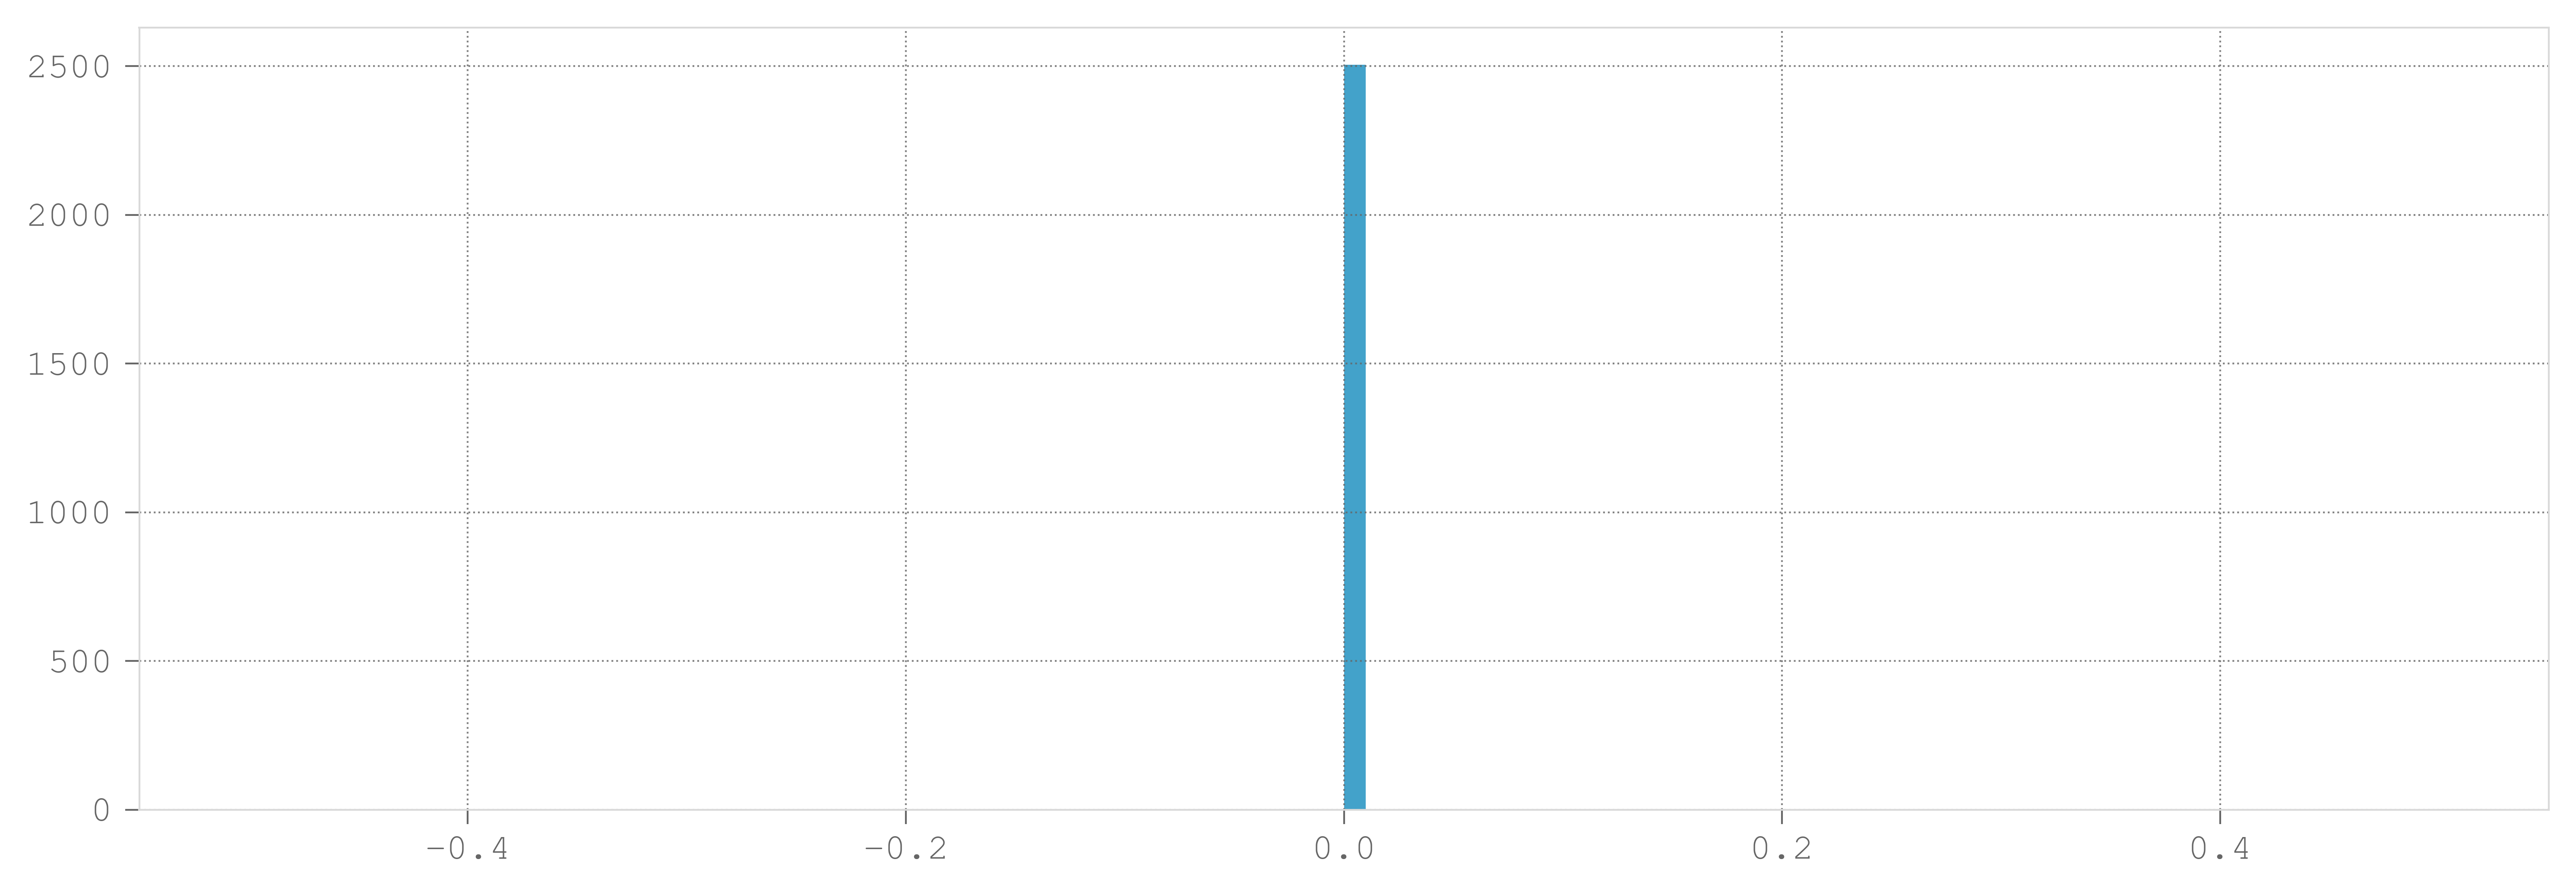

In [3]:
# Check training set angles 
plt.figure(figsize=(12, 4))
#plt.bar(range(len(y_train)), y_train, color='r')
plt.hist(y_train, bins=100); #, 100, normed=1, facecolor='r', alpha=0.75)
#plt.xlim(0,8000)


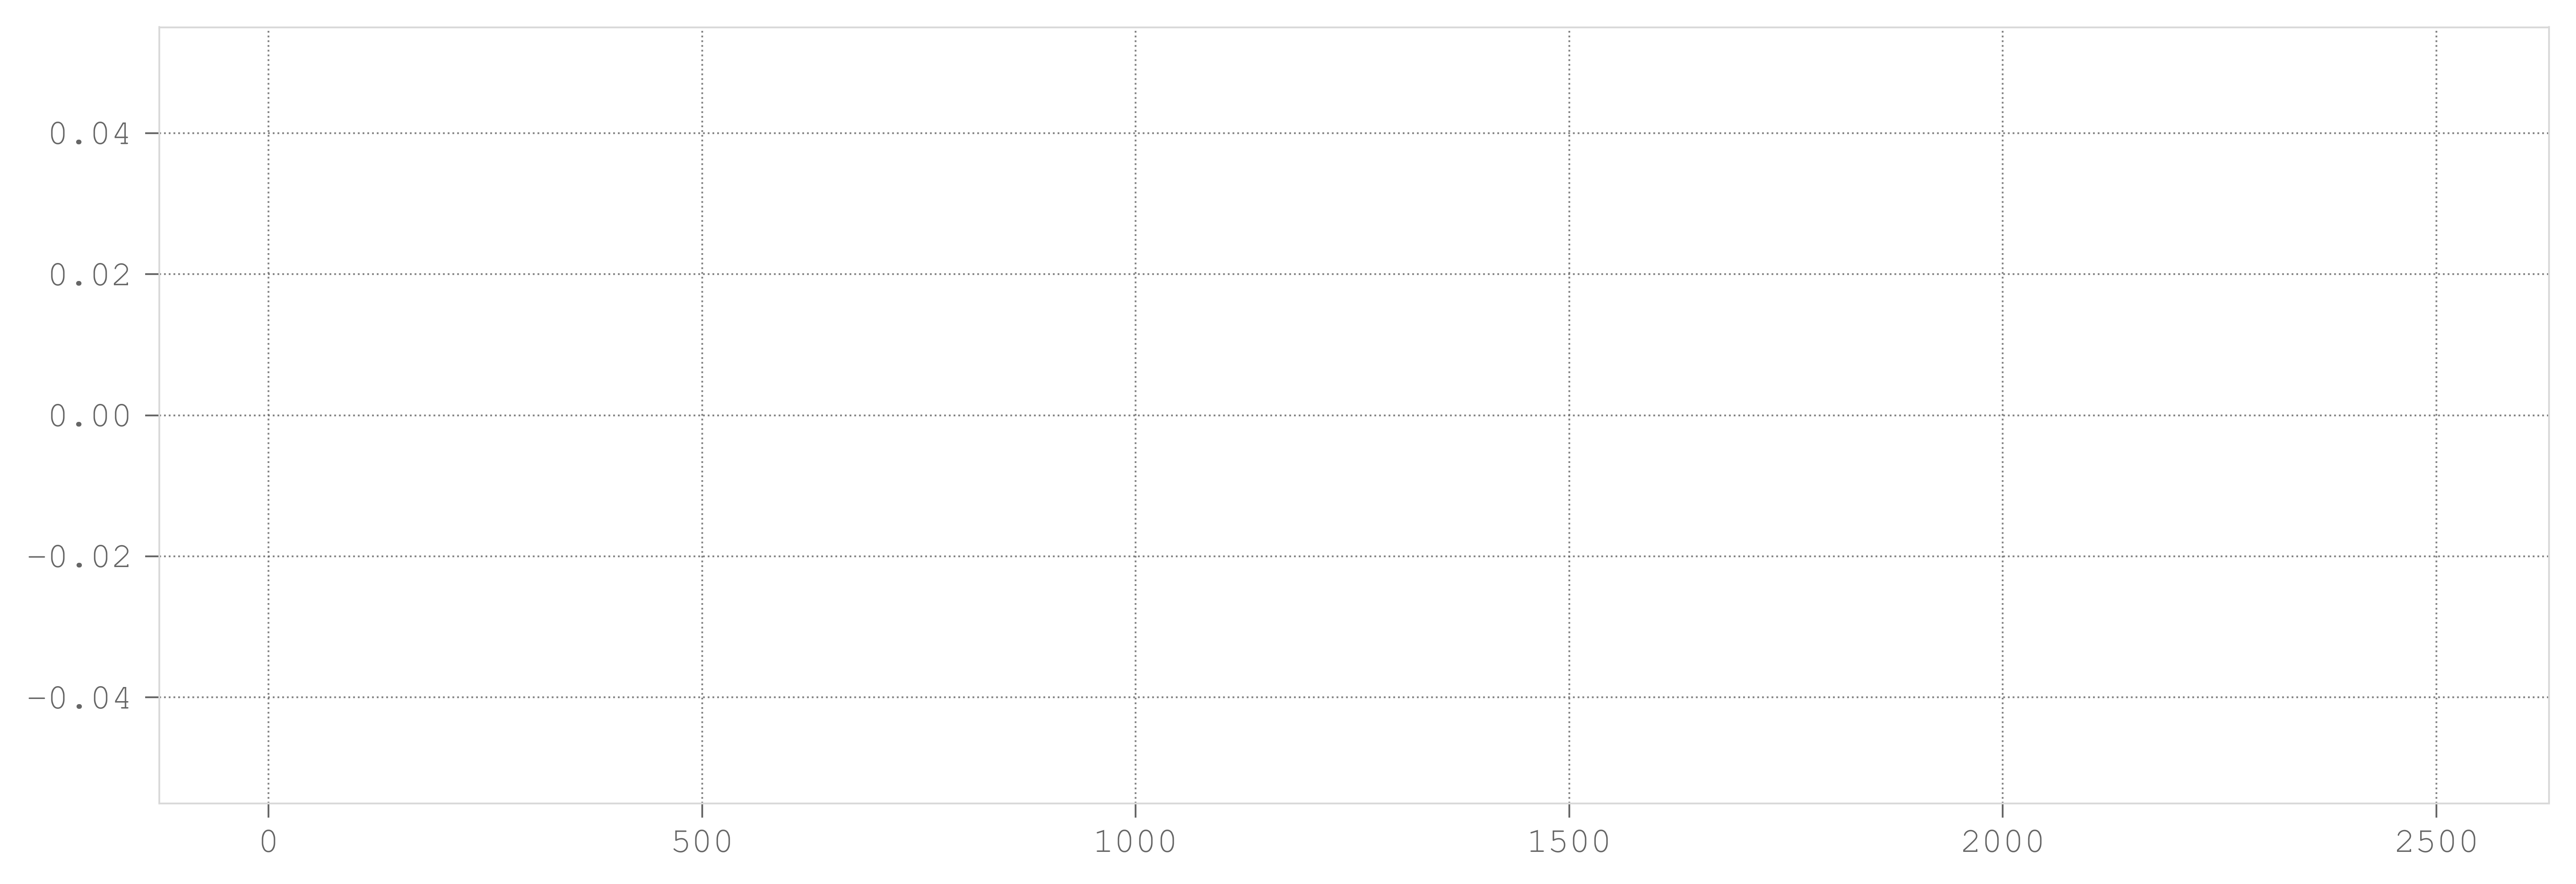

In [9]:
# Check training set angles 
plt.figure(figsize=(12, 4))
plt.bar(range(len(y_train)), y_train, color='r');
#plt.xlim(0,8000)


def generator(x_samples, y_samples, batch_size=128):
    idx=np.random.randint(len(x_samples)-batch_size-1)
    return x_samples[idx:idx+batch_size], y_samples[idx:idx+batch_size]

In [42]:
# Model based on https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
# Using keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Dense, Lambda, Cropping2D, Activation, Flatten

model = Sequential()

# pre process as described in lecture
# 1. Normalize input data
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(110,320,1))) 

# 2. Crop 70 pixels off the top and 20 pixels off the bottom of images
#model.add(Cropping2D(cropping=((70,25),(0,0)))) 

In [43]:
model.add(Conv2D(filters=16, kernel_size=5, strides=(2, 2), activation='relu'))
model.add(BatchNormalization(axis=1))
#model.add(Dropout(0.2))
model.add(Conv2D(filters=24, kernel_size=5, strides=(2, 2), activation='relu'))
#model.add(BatchNormalization(axis=1))
#model.add(Dropout(0.2))
model.add(Conv2D(filters=48, kernel_size=5, strides=(2, 2), activation='relu'))
#model.add(BatchNormalization(axis=1))
#model.add(Dropout(0.35))
model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation='relu'))
#model.add(Dropout(0.3))
model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation='relu'))
#model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# train model
#for x in range(10):
#    x, y = generator(X_train, y_train)
model.fit(X_train, y_train, validation_split=0.25, shuffle=True, epochs=3)
model.save('model.h5')

Train on 1878 samples, validate on 627 samples
Epoch 1/3
1878/1878 [==============================] - 108s - loss: 0.0013 - acc: 1.0000 - val_loss: 6.1810e-07 - val_acc: 1.0000

KeyboardInterrupt: 

**Behavioral Cloning Project**

The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report


#### Files Submitted & Code Quality

*1. Submission includes all required files and can be used to run the simulator in autonomous mode*

My project includes the following files:
* Model.ipynb containing the script to create and train the model
* drive.py for driving the car in autonomous mode; Changed the speed to 15 from the default udacity code
* model.h5 containing a trained convolution neural network
* writeup_report.md or writeup_report.pdf summarizing the results

*2. Submission includes functional code*
Using the Udacity provided simulator and my drive.py file, the car can be driven autonomously around the track by executing
```sh
python drive.py model.h5
```

*3. Submission code is usable and readable*
The Model.ipynb file contains the code for training and saving the convolution neural network. The file shows the pipeline I used for training and validating the model, and it contains comments to explain how the code works.

#### Model Architecture and Training Strategy

*1. An appropriate model architecture has been employed*

My model is a slightly modified version of the Nvidia architecture described in class (http://images.nvidia.com/content/tegra/automotive/images/ 2016/solutions/pdf/end-to-end-dl-using-px.pdf).
Figure 4 and "section 4 Network Architecture" provided all the details for the base implementation. I expermiented with different max pooloing   and dropout  layers. Finally settled on a single additional batch normalization layer after the first Convolution layer.

I also used the cropping layer + normalization layer as described in the lectures. This is done before the convolution layers.

*2. Attempts to reduce overfitting in the model*

Experimented with dropout layers. The best accuracy was with the additional batch norm layer.

The model was trained and validated on different data sets to ensure that the model was not overfitting. The model was tested by running it through the simulator and ensuring that the vehicle could stay on the track.

*3. Model parameter tuning*

The model used an adam optimizer, so the learning rate was not tuned manually.

*4. Appropriate training data*

I tried to generate my own images from running the simulator. The simulator did not work very well on my computer and would hang. I guess I need a more powerful machine. The fan on this laptop sounds like its on the verge of blowing up.
I eventually used the images provided. Center+left+right camera images. I flipped some randomly picked images as can be seen in the graph after  cnt 8000. I set the validation split to be 25%

#### Model Architecture and Training Strategy

*1. Solution Design Approach*
1. Try to collect training images using simulator
2. Used udacity training data
3. Crop and normalize layers using keras
4. Nvidia deep learning network model
5. Experiment with different batch norm/max pooling/drop out layers. Captured model.h5 files and moitored validation accuracy.
6. Tweaked the steering angle in the original training data and tried the network.
7. Picked the best model that runs on the simulator in auto mode

*2. Final Model Architecture*
Described above

*3. Creation of the Training Set & Training Process*
Collecting my own images did not work very well.
~